In [1]:
#importation of libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Convolution2D
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import cv2
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [2]:
#Parameters definition
num_classes = 4
img_width = 32
img_height = 32
input_shape = (img_height, img_width,3)

In [3]:
train_file = "./data/bosch_udacity_train.p"
test_file = "./data/bosch_udacity_test.p"

x_,y_ = pickle.load(open(train_file, "rb" ) )
random_state = 130
X_train, x_validation, y_train, y_validation = train_test_split(x_, y_, train_size = 0.80,
                                                                    test_size = 0.2,
                                                                    random_state = random_state)
# preprocess data
X_normalized = np.array(X_train / 255.0 - 0.5 )
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)

In [4]:
#Define the model

model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu',input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile('adam', 'categorical_crossentropy', ['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

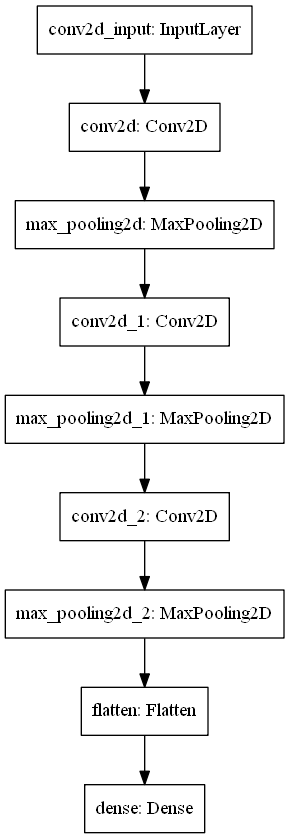

In [7]:
from keras.utils import plot_model
plot_model(model, to_file='model_architecture.png')

In [8]:
#Train the model

history = model.fit(X_normalized, y_one_hot, epochs=20, validation_split=0.2)

Epoch 1/20
186/186 [==============================] - 6s 11ms/step - loss: 0.5386 - accuracy: 0.8165 - val_loss: 0.2284 - val_accuracy: 0.9130
Epoch 2/20
186/186 [==============================] - 2s 9ms/step - loss: 0.2098 - accuracy: 0.9268 - val_loss: 0.1579 - val_accuracy: 0.9480
Epoch 3/20
186/186 [==============================] - 2s 11ms/step - loss: 0.1748 - accuracy: 0.9416 - val_loss: 0.2075 - val_accuracy: 0.9258
Epoch 4/20
186/186 [==============================] - 2s 10ms/step - loss: 0.1763 - accuracy: 0.9373 - val_loss: 0.1483 - val_accuracy: 0.9480
Epoch 5/20
186/186 [==============================] - 2s 11ms/step - loss: 0.1530 - accuracy: 0.9488 - val_loss: 0.1506 - val_accuracy: 0.9501
Epoch 6/20
186/186 [==============================] - 2s 10ms/step - loss: 0.1596 - accuracy: 0.9466 - val_loss: 0.1514 - val_accuracy: 0.9494
Epoch 7/20
186/186 [==============================] - 2s 10ms/step - loss: 0.1469 - accuracy: 0.9496 - val_loss: 0.1666 - val_accuracy: 0.9447


In [9]:
#Save the model
model.save('./models/model_traffic_light_classifier.h5')

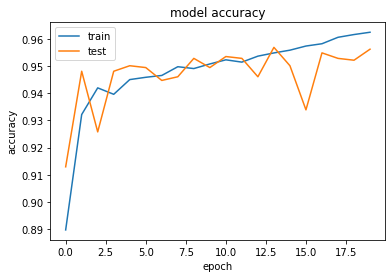

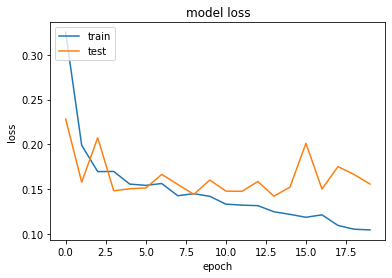

In [10]:
# Plot accuracy history 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./accuracy.png', dpi=100)

plt.show()


# Plot loss history 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./loss.png', dpi=100)
plt.show()

In [11]:
X_test,y_test = pickle.load(open(test_file, "rb" ) )

# preprocess data
X_normalized_test = np.array(X_test / 255.0 - 0.5 )
label_binarizer = LabelBinarizer()
y_one_hot_test = label_binarizer.fit_transform(y_test)

print("\nTesting\n")

metrics = model.evaluate(X_normalized_test, y_one_hot_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))


Testing

33/33 [==============================] - 0s 8ms/step - loss: 0.1748 - accuracy: 0.9553
loss: 0.17477574944496155
accuracy: 0.955339789390564


In [13]:
model=load_model('./models/model_traffic_light_classifier.h5')

img_test_path = "traffic_light_red.jpg"
img = cv2.imread(img_test_path)
img_resized = cv2.resize(img, (32,32), interpolation=cv2.INTER_LINEAR)
img_ = np.expand_dims(np.array(img_resized), axis=0)

states = ['red', 'yellow', 'green', 'off']
predicted_state = model.predict_classes(img_)
for idx in predicted_state:
    labels = states[idx]
    
if labels == 'green':
    color = (0, 255, 0)
elif labels == 'red':
    color = (0, 0, 255)
elif labels == 'yellow':
    color = (0,255,255)
else:
    color = (0, 0, 0)

cv2.putText(img, labels, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
name = "output_"+labels+".jpg"
result = cv2.imshow("output", img)
cv2.imwrite(name, img)
cv2.waitKey(0)
cv2.destroyAllWindows()